In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, f_classif
from scipy.stats import kruskal

In [3]:
df = pd.read_csv("../data/raw/data.csv")

# Compute minimum and maximum values for each column
min_values = df.min()
max_values = df.max()

# Combine into a single DataFrame for readability
min_max_df = pd.DataFrame({'Min Value': min_values, 'Max Value': max_values})

# Display the result
print("Minimum and Maximum Values for Each Column:")
print(min_max_df)

Minimum and Maximum Values for Each Column:
                        Min Value  Max Value
id                           8670  911320502
diagnosis                       B          M
radius_mean                 6.981      28.11
texture_mean                 9.71      39.28
perimeter_mean              43.79      188.5
area_mean                   143.5     2501.0
smoothness_mean           0.05263     0.1634
compactness_mean          0.01938     0.3454
concavity_mean                0.0     0.4268
concave points_mean           0.0     0.2012
symmetry_mean               0.106      0.304
fractal_dimension_mean    0.04996    0.09744
radius_se                  0.1115      2.873
texture_se                 0.3602      4.885
perimeter_se                0.757      21.98
area_se                     6.802      542.2
smoothness_se            0.001713    0.03113
compactness_se           0.002252     0.1354
concavity_se                  0.0      0.396
concave points_se             0.0    0.05279
symmetry_se

## Scaling the features

In [4]:
# Drop irrelevant columns
df_cleaned = df.drop(['id', 'Unnamed: 32'], axis=1)

# Encode diagnosis
df_cleaned['diagnosis'] = df_cleaned['diagnosis'].map({'B': 0, 'M': 1})

# Columns for scaling
columns_to_scale = [
    col for col in df_cleaned.columns 
    if col not in ['diagnosis'] and (df_cleaned[col].max() > 1 or df_cleaned[col].min() < 0)
]

# Initialize scaler
scaler = StandardScaler()

# Apply scaling
df_cleaned[columns_to_scale] = scaler.fit_transform(df_cleaned[columns_to_scale])

df_cleaned.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,1.097064,-2.073335,1.269934,0.984375,0.11840,0.27760,0.3001,0.14710,0.2419,...,1.886690,-1.359293,2.303601,2.001237,0.1622,2.616665,2.109526,0.2654,0.4601,0.11890
1,1,1.829821,-0.353632,1.685955,1.908708,0.08474,0.07864,0.0869,0.07017,0.1812,...,1.805927,-0.369203,1.535126,1.890489,0.1238,-0.430444,-0.146749,0.1860,0.2750,0.08902
2,1,1.579888,0.456187,1.566503,1.558884,0.10960,0.15990,0.1974,0.12790,0.2069,...,1.511870,-0.023974,1.347475,1.456285,0.1444,1.082932,0.854974,0.2430,0.3613,0.08758
3,1,-0.768909,0.253732,-0.592687,-0.764464,0.14250,0.28390,0.2414,0.10520,0.2597,...,-0.281464,0.133984,-0.249939,-0.550021,0.2098,3.893397,1.989588,0.2575,0.6638,0.17300
4,1,1.750297,-1.151816,1.776573,1.826229,0.10030,0.13280,0.1980,0.10430,0.1809,...,1.298575,-1.466770,1.338539,1.220724,0.1374,-0.313395,0.613179,0.1625,0.2364,0.07678


## Variance assessment

In [5]:
# Remove the target variable for variance assessment
X = df_cleaned.drop(columns=['diagnosis'])

# Calculate variance for each feature
variance = X.var()

# VarianceThreshold to identify features with low variance
threshold = 0.01
selector = VarianceThreshold(threshold=threshold)
X_var_selected = selector.fit_transform(X)

# Features with low variance
low_variance_features = X.columns[~selector.get_support()]
print(f"Features with low variance (below {threshold}):")
print(low_variance_features)

Features with low variance (below 0.01):
Index(['smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se',
       'symmetry_se', 'fractal_dimension_se', 'smoothness_worst',
       'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


## Correlation matrix with the target variable

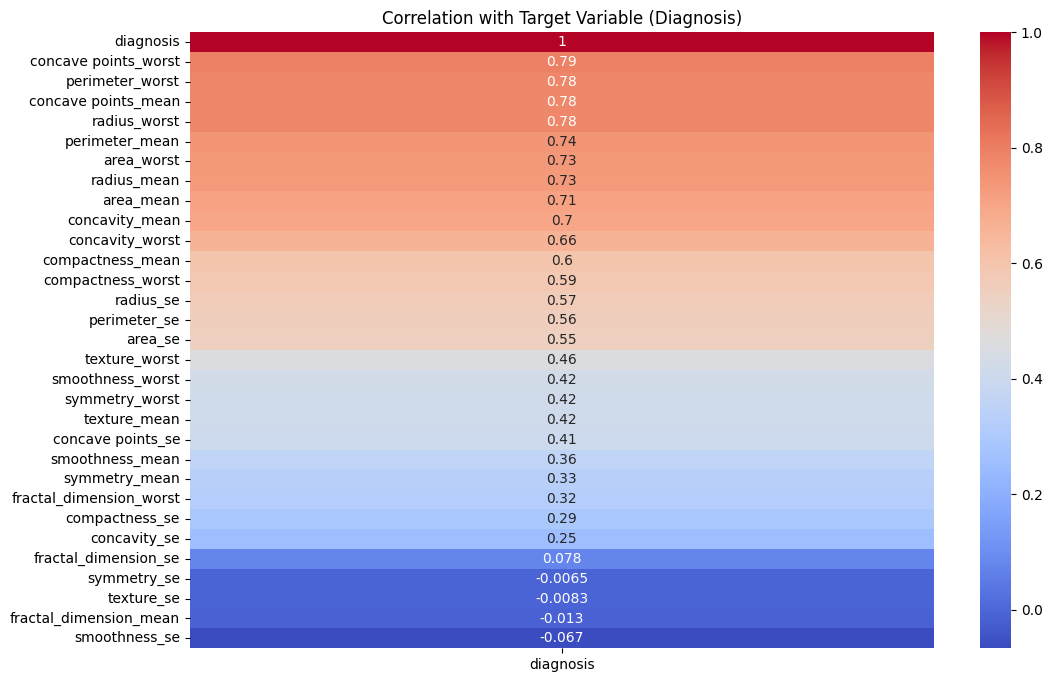

In [6]:
correlation = df_cleaned.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation[['diagnosis']].sort_values(by='diagnosis', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation with Target Variable (Diagnosis)")
plt.show()

## Feature Importance
### Using Random Forest Feature Importance, Mutual Information, ANOVA F-Test and Kruskal-Wallis H Test

In [7]:
# Define features and target
X = df_cleaned.drop(columns=['diagnosis'])
y = df_cleaned['diagnosis']

# Random Forest Feature Importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns)

# Mutual Information
mutual_info_scores = mutual_info_classif(X, y)
mutual_info_importances = pd.Series(mutual_info_scores, index=X.columns)

# ANOVA F-Test
f_scores, _ = f_classif(X, y)
anova_importances = pd.Series(f_scores, index=X.columns)

# Kruskal-Wallis H Test
kruskal_importances = []
for col in X.columns:
    groups = [X[col][y == label].values for label in y.unique()]
    h_stat, _ = kruskal(*groups)
    kruskal_importances.append(h_stat)
kruskal_importances = pd.Series(kruskal_importances, index=X.columns)

# Results in a DataFrame
feature_comparison = pd.DataFrame({
    'Random Forest': rf_importances,
    'Mutual Information': mutual_info_importances,
    'ANOVA F-Test': anova_importances,
    'Kruskal-Wallis': kruskal_importances,
})

# Select top 22 features for each method
top_features = {}
for method in feature_comparison.columns:
    top_features[method] = feature_comparison[method].nlargest(22).index.tolist()

# Create a DataFrame to compare top features
comparison_df = pd.DataFrame(top_features)
print("Top 22 Features for Each Method")
comparison_df

Top 22 Features for Each Method


,Random Forest,Mutual Information,ANOVA F-Test,Kruskal-Wallis
0,area_worst,perimeter_worst,concave points_worst,perimeter_worst
1,concave points_worst,area_worst,perimeter_worst,radius_worst
2,concave points_mean,radius_worst,concave points_mean,area_worst
3,radius_worst,concave points_mean,radius_worst,concave points_worst
4,perimeter_worst,concave points_worst,perimeter_mean,concave points_mean
5,perimeter_mean,perimeter_mean,area_worst,perimeter_mean
6,concavity_mean,concavity_mean,radius_mean,area_mean
7,area_mean,radius_mean,area_mean,concavity_mean
8,concavity_worst,area_mean,concavity_mean,radius_mean
9,radius_mean,area_se,concavity_worst,area_se


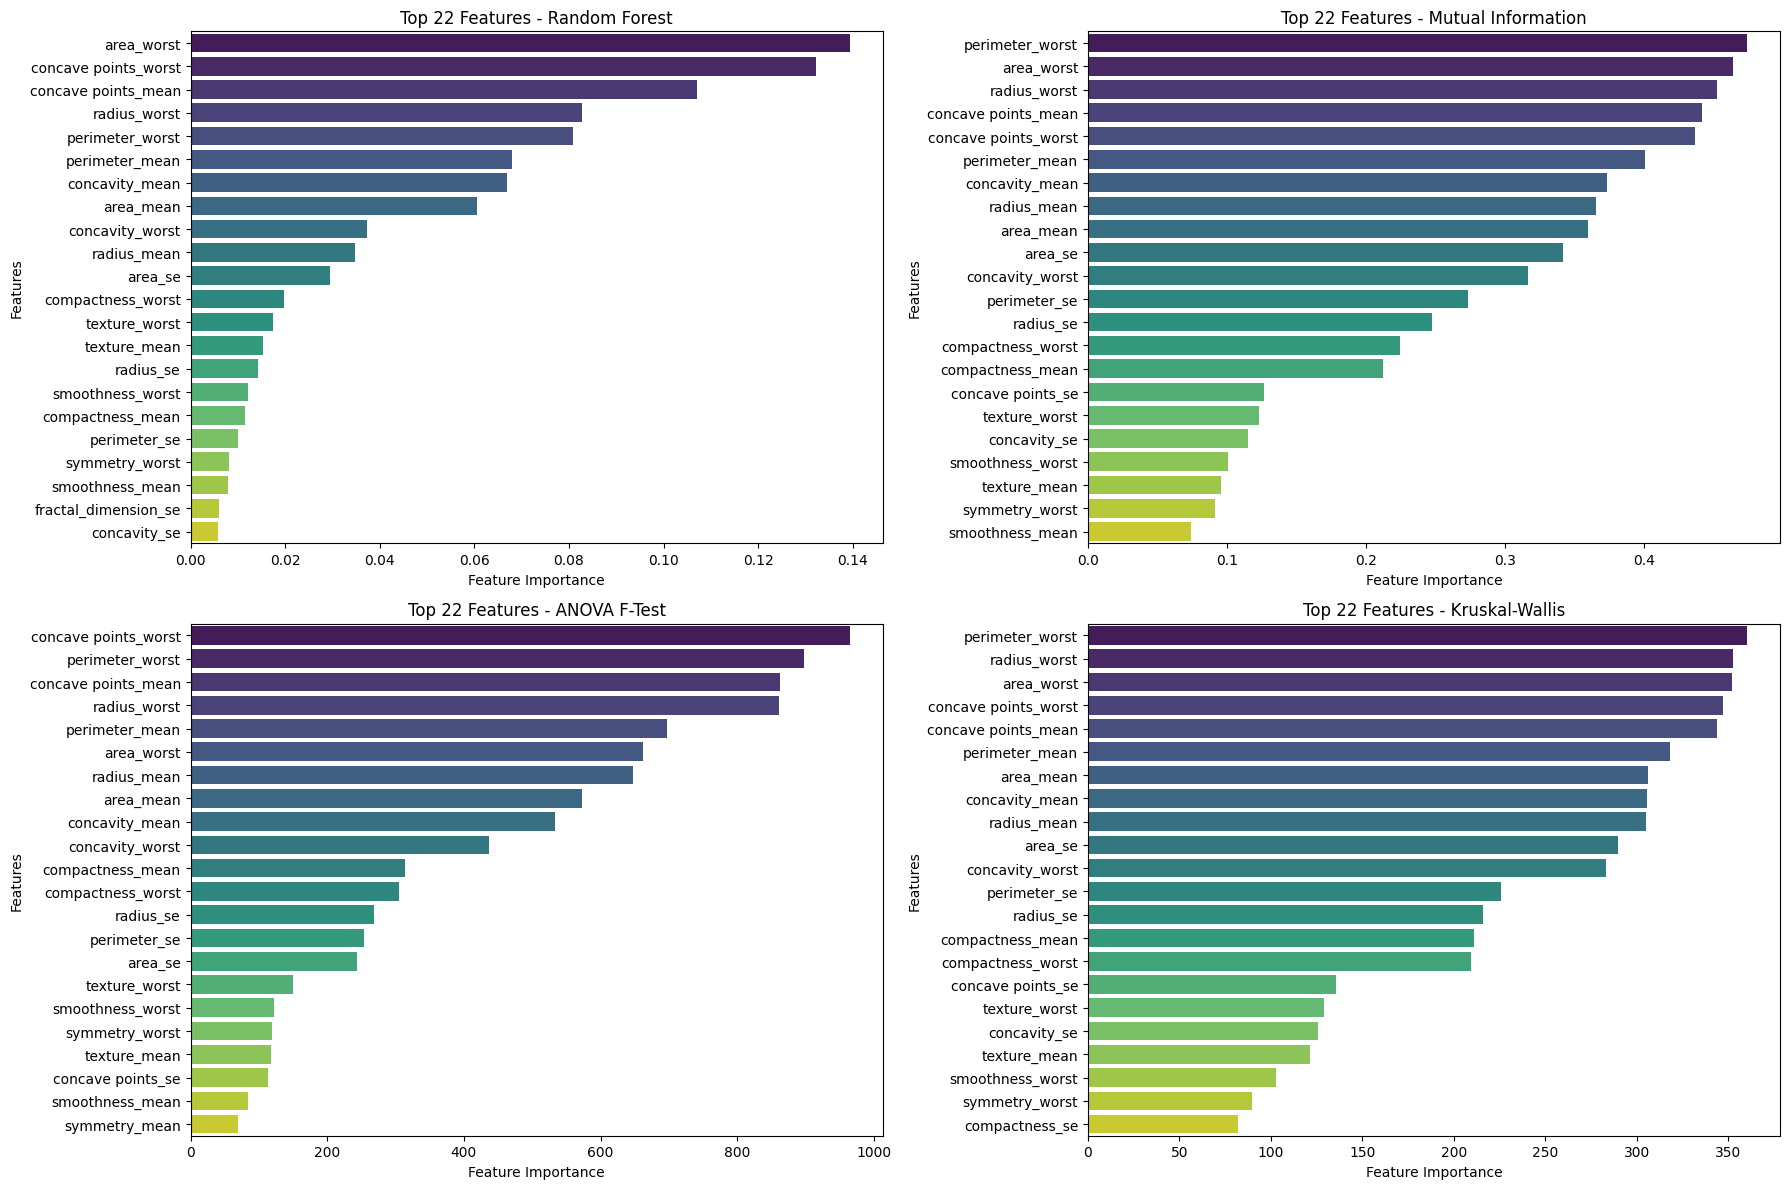

In [8]:
methods = feature_comparison.columns
n_methods = len(methods)

# Create subplots with 2 rows and 3 columns
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Flatten axes
axes = axes.flatten()

# Plot barplot for each method
for i, method in enumerate(methods):
    # Get the top 22 features for the method
    top_features = feature_comparison[method].nlargest(22)
    
    # Plot the barplot
    sns.barplot(x=top_features.values, y=top_features.index, ax=axes[i], palette="viridis")
    
    # Set title and labels for each subplot
    axes[i].set_title(f"Top 22 Features - {method}")
    axes[i].set_xlabel("Feature Importance")
    axes[i].set_ylabel("Features")

# Hide extra axes if the number of methods is less than the number of subplots
for i in range(n_methods, len(axes)):
    axes[i].axis('off')

# Adjust layout for a more compact arrangement
plt.tight_layout()
plt.show()

In [9]:
# The frequency of features in each method
feature_frequency = comparison_df.apply(pd.Series.value_counts, axis=0).fillna(0)

print("Frequency of Features in Top 22 Across All Methods")
feature_frequency

Frequency of Features in Top 22 Across All Methods


,Random Forest,Mutual Information,ANOVA F-Test,Kruskal-Wallis
area_mean,1.0,1.0,1.0,1.0
area_se,1.0,1.0,1.0,1.0
area_worst,1.0,1.0,1.0,1.0
compactness_mean,1.0,1.0,1.0,1.0
compactness_se,0.0,0.0,0.0,1.0
compactness_worst,1.0,1.0,1.0,1.0
concave points_mean,1.0,1.0,1.0,1.0
concave points_se,0.0,1.0,1.0,1.0
concave points_worst,1.0,1.0,1.0,1.0
concavity_mean,1.0,1.0,1.0,1.0


In [10]:
# The features that appear in all methods
features_in_all_methods = feature_frequency[feature_frequency.sum(axis=1) == len(feature_comparison.columns)]
print("Top features present in all methods:")
features_in_all_methods

Top features present in all methods:


,Random Forest,Mutual Information,ANOVA F-Test,Kruskal-Wallis
area_mean,1.0,1.0,1.0,1.0
area_se,1.0,1.0,1.0,1.0
area_worst,1.0,1.0,1.0,1.0
compactness_mean,1.0,1.0,1.0,1.0
compactness_worst,1.0,1.0,1.0,1.0
concave points_mean,1.0,1.0,1.0,1.0
concave points_worst,1.0,1.0,1.0,1.0
concavity_mean,1.0,1.0,1.0,1.0
concavity_worst,1.0,1.0,1.0,1.0
perimeter_mean,1.0,1.0,1.0,1.0


In [11]:
# List of selected columns
selected_columns = [
    'diagnosis', 'area_mean', 'area_se', 'area_worst', 'compactness_mean', 'compactness_worst',
    'concave points_mean', 'concave points_worst', 'concavity_mean', 'concavity_worst',
    'perimeter_mean', 'perimeter_se', 'perimeter_worst', 'radius_mean', 'radius_se',
    'radius_worst', 'smoothness_worst', 'symmetry_worst', 'texture_mean', 'texture_worst'
]

# Create a cleaned dataframe with only the selected columns
data_cleaned = df_cleaned[selected_columns]

# Display the cleaned data
data_cleaned

,diagnosis,area_mean,area_se,area_worst,compactness_mean,compactness_worst,concave points_mean,concave points_worst,concavity_mean,concavity_worst,perimeter_mean,perimeter_se,perimeter_worst,radius_mean,radius_se,radius_worst,smoothness_worst,symmetry_worst,texture_mean,texture_worst
0,1,0.984375,2.487578,2.001237,0.27760,2.616665,0.14710,0.2654,0.30010,2.109526,1.269934,2.833031,2.303601,1.097064,2.489734,1.886690,0.16220,0.4601,-2.073335,-1.359293
1,1,1.908708,0.742402,1.890489,0.07864,-0.430444,0.07017,0.1860,0.08690,-0.146749,1.685955,0.263327,1.535126,1.829821,0.499255,1.805927,0.12380,0.2750,-0.353632,-0.369203
2,1,1.558884,1.181336,1.456285,0.15990,1.082932,0.12790,0.2430,0.19740,0.854974,1.566503,0.850928,1.347475,1.579888,1.228676,1.511870,0.14440,0.3613,0.456187,-0.023974
3,1,-0.764464,-0.288378,-0.550021,0.28390,3.893397,0.10520,0.2575,0.24140,1.989588,-0.592687,0.286593,-0.249939,-0.768909,0.326373,-0.281464,0.20980,0.6638,0.253732,0.133984
4,1,1.826229,1.190357,1.220724,0.13280,-0.313395,0.10430,0.1625,0.19800,0.613179,1.776573,1.273189,1.338539,1.750297,1.270543,1.298575,0.13740,0.2364,-1.151816,-1.466770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,2.343856,2.604187,2.015301,0.11590,-0.273318,0.13890,0.2216,0.24390,0.664512,2.060786,2.379583,1.752563,2.110995,2.782080,1.901185,0.14100,0.2060,0.721473,0.117700
565,1,1.723842,1.291565,1.494959,0.10340,-0.394820,0.09791,0.1628,0.14400,0.236573,1.615931,1.156857,1.421940,1.704854,1.300499,1.536720,0.11660,0.2572,2.085134,2.047399
566,1,0.577953,0.180698,0.427906,0.10230,0.350735,0.05302,0.1418,0.09251,0.326767,0.672676,0.276693,0.579001,0.702284,0.184892,0.561361,0.11390,0.2218,2.045574,1.374854
567,1,1.735218,1.009503,1.653171,0.27700,3.904848,0.15200,0.2650,0.35140,3.197605,1.982524,1.438530,2.303601,1.838341,1.157935,1.961239,0.16500,0.4087,2.336457,2.237926


In [12]:
# Save the new dataset
data_cleaned.to_csv("../data/processed/data_cleaned.csv", index=False)